In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from itertools import product

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.utility.visualisation import Experiment, get_N_U_sample, get_arrivals_sample, plot_trajectories, plot_marginal_laws, poisson_jumps_test

plt.style.use('seaborn-v0_8-deep')
plt.style.use('default')  # 'default' or any other light theme like 'seaborn-white'

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

## Experiment choice: Visualisation of the trajectories

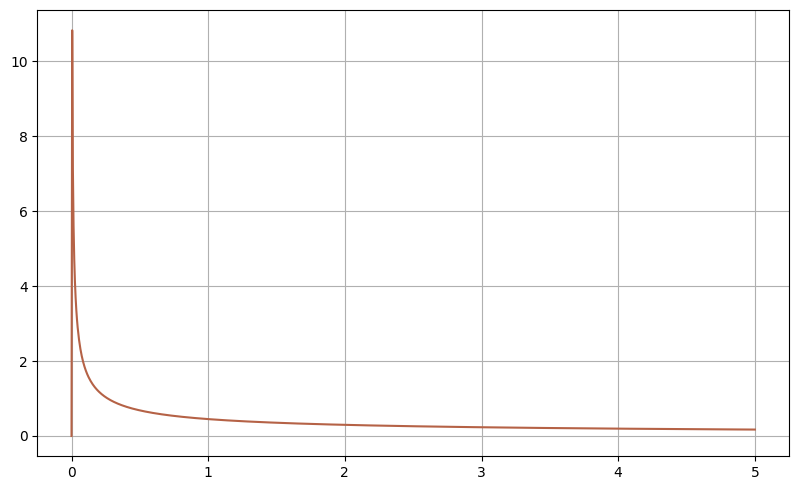

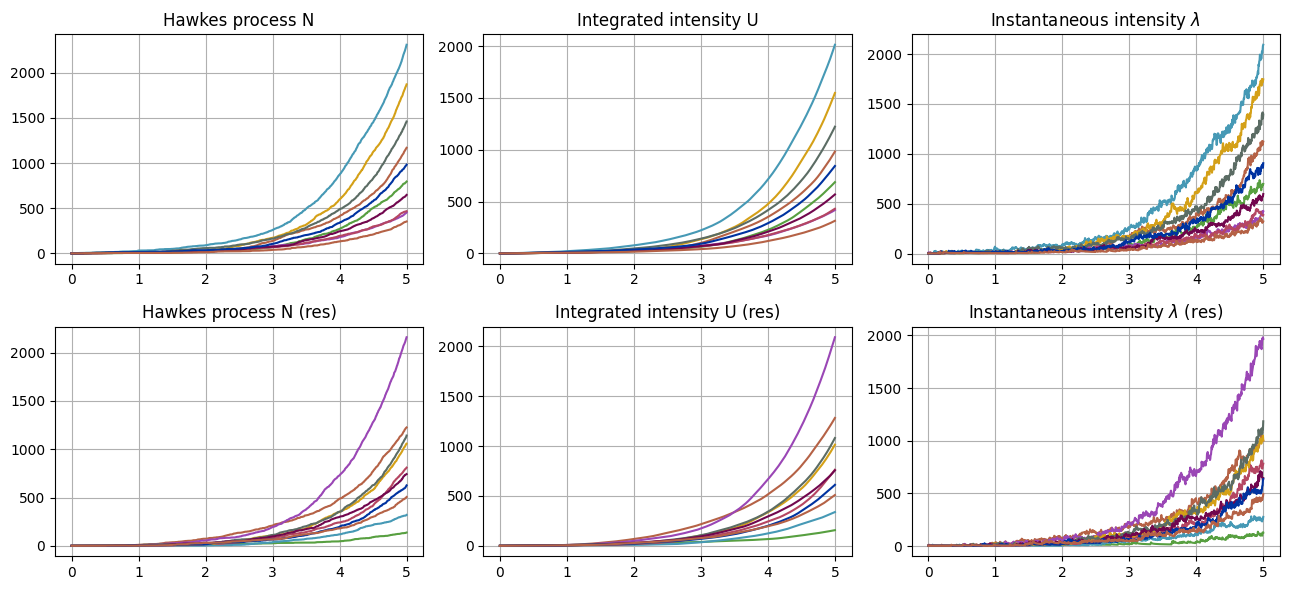

In [2]:
# mu = 3
# H = 0.3
# lam = 1
# c = 2
# alpha = 2

# T = 1
# n_steps = 1000

# rng = np.random.default_rng(seed=42)

#K = ConstantKernel(c=3)
#K = FractionalKernel(H=H, c=c)
#K = ExponentialKernel(c=c, lam=lam)
#K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha)


e = Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=-0.1, c=1),
    mu=3
)

# e = Experiment(
#     T=5,
#     n_steps = 1000,
#     kernel = ExponentialKernel(lam=5, c=6),
#     mu=3
# )

# lam = 5
# alpha = 4
# t0 = (alpha - 1) / lam
# gamma_kernel = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 2)
# e = Experiment(
#     T=4,
#     n_steps = 100,
#     kernel = gamma_kernel,
#     decreasing_kernel=lambda t: gamma_kernel(t) * (t > t0) + gamma_kernel(t0) * (t <= t0),
#     mu=3
# )

# e = Experiment(
#     T=5,
#     n_steps = 1000,
#     kernel = ConstantKernel(c=0.1),
#     mu=3
# )

plt.plot(e.t_grid, e.kernel(e.t_grid))
if e.decreasing_kernel is not None:
    plt.plot(e.t_grid, e.decreasing_kernel(e.t_grid))
plot_trajectories(e)


In [3]:
lam_gamma = 5
alpha_gamma = 4
t0_gamma = (alpha_gamma - 1) / lam_gamma
gamma_kernel = GammaKernel(lam=lam_gamma, alpha=alpha_gamma, c=lam_gamma**alpha_gamma * 2)

experiments_list = [
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.3, c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0., c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.1, c=0.5),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.1, c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=-0.1, c=1),
    mu=3
    ),
    Experiment(
    T=4,
    n_steps = 100,
    kernel = gamma_kernel,
    decreasing_kernel=lambda t: gamma_kernel(t) * (t > t0) + gamma_kernel(t0) * (t <= t0),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ConstantKernel(c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ConstantKernel(c=0.1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ExponentialKernel(lam=5, c=5),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ExponentialKernel(lam=1, c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ExponentialKernel(lam=5, c=6),
    mu=3
    )
]

In [7]:
def run_test0(e, path_experiment, experiment_results):
    # test 0: plot the kernel and sample trajectories
    fig, ax = plt.subplots()
    ax.plot(e.t_grid, e.kernel(e.t_grid))
    fig.savefig(path_experiment + "kernel.pdf", format="pdf", bbox_inches="tight", transparent=True)

    plot_trajectories(e, path=path_experiment + "sample_trajectories.pdf")


def run_test1(e, path_experiment, experiment_results):
    # test 1: compute E[N_T]
    rng = np.random.default_rng(seed=42)
    ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0)
    expected_U = ivi_hawkes.U_mean(t_grid=np.linspace(e.t_grid[0], e.t_grid[-1], 1000))
    experiment_results["mean_N_T"] = expected_U[-1]
    print("Mean:", experiment_results["mean_N_T"])


def run_test2(e, path_experiment, experiment_results):
    # test 2: marginal laws
    n_paths = 5000
    n_steps_arr = [10, 50, 100, 1000]
    ivi_methods = ["iVi", "Res iVi"]
    non_ivi_methods = ["Population", "Ogata"]
    print("Computing non-iVi samples...")
    samples = {method: get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method in non_ivi_methods}
    print("Computing iVi samples...")
    for n_steps in n_steps_arr:
        print("n_steps =", n_steps)
        for method in ivi_methods:
            samples[method] = get_N_U_sample(experiment=e.change_n_steps(n_steps), method=method, n_paths=n_paths, return_counters=True)
        experiment_results["U_p_values_" + str(n_steps)] = plot_marginal_laws(samples, "U", path=path_experiment + "marginal_laws_U_" + str(n_steps) + ".pdf")
        experiment_results["N_p_values_" + str(n_steps)] = plot_marginal_laws(samples, "N", path=path_experiment + "marginal_laws_N_" + str(n_steps) + ".pdf")


def run_test3(e, path_experiment, experiment_results):
    # test 3: convergence of the CF
    print("Computing iVi samples...")
    methods_ivi = ["iVi", "Res iVi"]
    n_steps_arr = [10, 20, 35, 50, 65, 80, 100, 200]
    n_paths = 1_000_000
    experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]
    samples = {(method, e.n_steps): get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True)
               for method, e in product(methods_ivi, experiments)}

    print("Computing non-iVi samples...")
    methods_non_ivi = ["Population", "Ogata"]
    n_paths_non_ivi = 10_000
    samples_non_ivi = {method: get_N_U_sample(experiment=experiments[-1], method=method, n_paths=n_paths_non_ivi, return_counters=True)
                       for method in methods_non_ivi}

    w = -0.01
    fun = lambda x: np.exp(w * x)
    cf_ref = {}

    for mode in ["U", "N"]:
        idx = 1 if mode == "U" else 0

        rng = np.random.default_rng(seed=42)
        ivi = IVIHawkesProcess(kernel=experiments[-1].kernel, g0_bar=experiments[-1].g0_bar, rng=rng,
                               g0=experiments[-1].g0, resolvent_flag=False)
        cf_ref[mode] = ivi.characteristic_function(T=experiments[-1].T, w=w, n_steps=10000, mode=mode)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    errors_ivi = {}
    for mode in ["U", "N"]:
        idx = 1 if mode == "U" else 0
        print("Reference value:", cf_ref[mode])

        mc_std = 3 * fun(samples_non_ivi["Population"][idx][:, -1]).std() / np.sqrt(n_paths)

        errors_ivi[mode] = {}
        methods = ["iVi", "Res iVi"]

        for method in methods:
            errors_ivi[mode][method]  = []
            for e in experiments:
                U = samples[(method, e.n_steps)][idx]
                errors_ivi[mode][method].append(np.abs(cf_ref[mode] - fun(U[:, -1]).mean()))
            ax[idx].loglog(n_steps_arr, errors_ivi[mode][method], label=method)
        ax[idx].hlines(y=3 * mc_std, xmin=n_steps_arr[0], xmax=n_steps_arr[-1], color="k", linestyles="--")
        ax[idx].set_title(f"Characteristic function of ${mode}_T$")
        ax[idx].legend()
    fig.savefig(path_experiment + "CF_convergence_1.pdf", format="pdf", bbox_inches="tight", transparent=True)


    fig, ax_arr = plt.subplots(1, 2, figsize=(12, 4))
    for mode in ["U", "N"]:
        idx = 1 if mode == "U" else 0
        ax = ax_arr[idx]
        for method in methods:
            ax.scatter(errors_ivi[mode][method], 2 * np.array(n_steps_arr), marker="x", label=method)

        for method, color in zip(methods_non_ivi, color_cycle[3:]):
            error = np.abs(cf_ref[mode] - fun(samples_non_ivi[method][idx][:, -1]).mean())
            parts= ax.violinplot(samples_non_ivi[method][2], positions=[3*mc_std], widths=0.001, showmeans=True, showextrema=False)
            ax.scatter([], [], c=color, label=method)
            for pc in parts['bodies']:
                pc.set_facecolor(color)  # blue fill
                pc.set_edgecolor('black')    # black outline
            parts['cmeans'].set_color(color)

        ax.vlines(x=3*mc_std, ymin=0, ymax=np.max(samples_non_ivi["Ogata"][2]), color="k", linestyles="--")

        ax.legend()
        ax.set_xlim([0, 0.01])
        ax.set_xlabel("Absolute error")
        ax.set_ylabel("Simulations per trajectory")
        ax.set_title(f"Convergence of the CF of ${mode}_T$")
    fig.savefig(path_experiment + "CF_convergence_2.pdf", format="pdf", bbox_inches="tight", transparent=True)


    fig, ax_arr = plt.subplots(1, 2, figsize=(12, 4))
    for mode in ["U", "N"]:
        idx = 1 if mode == "U" else 0
        ax = ax_arr[idx]

        for method, color in zip(methods_non_ivi, color_cycle[3:]):
            error = np.abs(cf_ref[mode] - fun(samples_non_ivi[method][idx][:, -1]).mean())
            hist = ax.hist(samples_non_ivi[method][2], color=color, label=method, density=True, bins=100, alpha=0.5)
            ax.vlines(np.mean(samples_non_ivi[method][2]), 0, hist[0].max(), linestyles="--", color=color)

        ax.set_xlim([0, np.max(samples_non_ivi["Ogata"][2])])

        # Create second y-axis
        ax2 = ax.twinx()

        for method in methods:
            ax2.scatter(2 * np.array(n_steps_arr), errors_ivi[mode][method],  marker="x", label=method)

        ax2.hlines(y=3*mc_std, xmin=0, xmax=np.max(samples_non_ivi["Ogata"][2]), color="k", linestyles="--")
        ax2.set_ylim([0, 20*mc_std])


        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2)
        ax2.grid(False)

        ax.set_xlabel("Simulations per trajectory")
        ax.set_ylabel("Density")

        # ax.set_xlim([0, 0.01])
        ax2.set_ylabel("Absolute error")
        ax.set_title(f"Convergence of the CF of ${mode}_T$")
    fig.savefig(path_experiment + "CF_convergence_3.pdf", format="pdf", bbox_inches="tight", transparent=True)


def run_test4(e, path_experiment, experiment_results):
    # test 4: sampling arrivals
    methods = ["Population", "Ogata", "iVi", "Res iVi"]
    n_steps_arr = [10, 50, 100, 1000]
    for n_steps in n_steps_arr:
        rng = np.random.default_rng(seed=42)
        experiment_results["arriavals_p_values_" + str(n_steps)] = dict()
        fig, ax = plt.subplots(4, 3, figsize=(12, 3*4))
        for i, method in enumerate(methods):
            samples_arrivals = get_arrivals_sample(experiment=e.change_n_steps(n_steps), method=method, n_paths=1, rng=rng)
            print(method)
            ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0, resolvent_flag=False)
            experiment_results["arriavals_p_values_" + str(n_steps)][method] = poisson_jumps_test(ivi_hawkes.U_from_jumps(samples_arrivals[0],
                                                                                                          samples_arrivals[0]),
                                                                                  ax=ax[i])
        fig.savefig(path_experiment + "arrivals_" + str(n_steps) + ".pdf", format="pdf", bbox_inches="tight", transparent=True)

In [8]:
plt.plot([0, 1], [0, 1])
plt.savefig('test.pdf')
plt.close('all')

plt.plot([0, 1], [1, 1])
plt.savefig('test2.pdf')
plt.close('all')

In [ ]:
e = experiments_list[0]

print("RUNNING EXPERIMENT", str(e))
path = "../experiments/"
path_experiment = path + str(e) + "/"
try:
    os.mkdir(path_experiment)
except FileExistsError as _:
    pass

experiment_results = dict()

print("RUNNING TEST 3, EXPERIMENT", str(e))
run_test3(e, path_experiment, experiment_results)

RUNNING EXPERIMENT Experiment(T=5, n_steps=1000, kernel=FractionalKernel(c=1, H=0.3), mu=3, decreasing_kernel=None)
RUNNING TEST 3, EXPERIMENT Experiment(T=5, n_steps=1000, kernel=FractionalKernel(c=1, H=0.3), mu=3, decreasing_kernel=None)
Computing iVi samples...


In [ ]:
path = "../experiments/"

for e in experiments_list:
    print("RUNNING EXPERIMENT", str(e))
    path_experiment = path + str(e) + "/"
    try:
        os.mkdir(path_experiment)
    except FileExistsError as _:
        pass

    experiment_results = dict()

    print("RUNNING TEST 0, EXPERIMENT", str(e))
    run_test0(e, path_experiment, experiment_results)
    print("RUNNING TEST 1, EXPERIMENT", str(e))
    run_test1(e, path_experiment, experiment_results)
    print("RUNNING TEST 2, EXPERIMENT", str(e))
    run_test2(e, path_experiment, experiment_results)
    print("RUNNING TEST 3, EXPERIMENT", str(e))
    run_test3(e, path_experiment, experiment_results)
    print("RUNNING TEST 4, EXPERIMENT", str(e))
    run_test4(e, path_experiment, experiment_results)

    plt.close('all')
    # saving the results
    with open(path_experiment + 'results.json', 'w') as f:
        json.dump(experiment_results, f)

RUNNING EXPERIMENT Experiment(T=5, n_steps=1000, kernel=FractionalKernel(c=1, H=0.3), mu=3, decreasing_kernel=None)
RUNNING TEST 0, EXPERIMENT Experiment(T=5, n_steps=1000, kernel=FractionalKernel(c=1, H=0.3), mu=3, decreasing_kernel=None)
RUNNING TEST 1, EXPERIMENT Experiment(T=5, n_steps=1000, kernel=FractionalKernel(c=1, H=0.3), mu=3, decreasing_kernel=None)
Mean: 551.4569644020899
RUNNING TEST 2, EXPERIMENT Experiment(T=5, n_steps=1000, kernel=FractionalKernel(c=1, H=0.3), mu=3, decreasing_kernel=None)


/home/dimitri/PycharmProjects/volterra_hawkes/volterra_hawkes/iVi/iVi.py:58: UserWarning: Negative alpha encountered in iVi Res scheme. Setting to 0.
  warnings.warn(f"Negative alpha encountered in {scheme_name} scheme. Setting to 0.")


p-value Population-Ogata: 0.5441874830769005
KstestResult(statistic=np.float64(0.016), pvalue=np.float64(0.5441874830769005), statistic_location=np.float64(505.41333958245673), statistic_sign=np.int8(-1))
p-value Population-iVi: 0.0
KstestResult(statistic=np.float64(0.739), pvalue=np.float64(0.0), statistic_location=np.float64(948.9264921478834), statistic_sign=np.int8(-1))
p-value Population-Res iVi: 1.1788183256231002e-26
KstestResult(statistic=np.float64(0.1098), pvalue=np.float64(1.1788183256231002e-26), statistic_location=np.float64(150.40974772991183), statistic_sign=np.int8(1))
p-value Population-Ogata: 0.45029268979401865
KstestResult(statistic=np.float64(0.0172), pvalue=np.float64(0.45029268979401865), statistic_location=np.int64(497), statistic_sign=np.int8(-1))
p-value Population-iVi: 0.0
KstestResult(statistic=np.float64(0.9284), pvalue=np.float64(0.0), statistic_location=np.float64(1463.0), statistic_sign=np.int8(-1))
p-value Population-Res iVi: 4.717961598021151e-25
Kstes